In [41]:
import os
import random
import copy
import math
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import gc
import glob
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset

In [2]:
device = torch.device('cpu') if torch.backends.mps.is_available() else torch.device('cpu')
print(device)

cpu


# param setting

In [3]:
EPOCHS = 200
LR = 1e-3
BS = 32
SEED = 42
MODEL_NAME ='ver_8_model_type'
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(SEED) # Seed 고정

# Data loading

In [4]:
train_df = pd.read_csv('./dataset/train_data.csv')
test_df = pd.read_csv('./dataset/test_data.csv')

# Data scaling

In [5]:
train_each_list = []
train_each_list.append(train_df.loc[train_df['type']==0])
train_each_list.append(train_df.loc[train_df['type']==1])
train_each_list.append(train_df.loc[train_df['type']==2])
train_each_list.append(train_df.loc[train_df['type']==3])
train_each_list.append(train_df.loc[train_df['type']==4])
train_each_list.append(train_df.loc[train_df['type']==5])
train_each_list.append(train_df.loc[train_df['type']==6])
train_each_list.append(train_df.loc[train_df['type']==7])

# Make custom dataset

In [6]:
class MyDataset(Dataset):
    def __init__(self, origin_x):
        self.data = origin_x
        
    def __getitem__(self, index):
        self.x = self.data[index]
        return torch.Tensor(self.x)

    def __len__(self):
        return len(self.data)

#Pytorch를 사용하기 위해 custom dataset 구성해줌

# AE Model

In [7]:
class AutoEncoder(nn.Module):
    def __init__(self,in_features):
        super(AutoEncoder, self).__init__()
        self.feature_num = in_features
        self.Encoder = nn.Sequential(
            nn.Linear(in_features,8),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.Linear(8,64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
        )
        self.Decoder = nn.Sequential(
            nn.Linear(64,8),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.Linear(8,in_features),
        )

        self.init_weight()

    def forward(self, x):
        encoded = self.Encoder(x)
        decoded = self.Decoder(encoded)
        return decoded, encoded

    def init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant(m.weight, 1)
                nn.init.constant(m.bias, 0)

# Training class

In [8]:
class Trainer():
    def __init__(self, model, optimizer, train_loader, val_loader, scheduler, device):
        self.model = model
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.scheduler = scheduler
        self.device = device
        # Loss Function
        self.criterion = nn.MSELoss().to(self.device)
        
    def fit(self, index):
        self.model.to(self.device)
        best_loss = 1000000000
        for epoch in range(EPOCHS):
            self.model.train()
            train_loss = []
            i = 1
            for x in iter(self.train_loader):
                x = x.float().to(self.device)
                self.optimizer.zero_grad()
                _x,_ = self.model(x)
                loss = self.criterion(x,_x)
                loss.backward()
                self.optimizer.step()
                train_loss.append(loss.item())
                i=i+1
                
            val_loss, mse_list = self.validation(self.model)
            
            mean_train_loss = np.mean(train_loss)
            
            #print(f'Epoch : [{epoch+1}] Train loss : [{mean_train_loss}] val loss : [{val_loss}]\n')
            
            self.scheduler.step(val_loss)
            
            if best_loss > val_loss:
                best_loss = val_loss
                torch.save(self.model, './' + MODEL_NAME+str(index)+'.pth')
                #print("Save Model~_~")
                
            #plt.plot(mse_list)
            #plt.show()
            
            
        print(best_loss)
           
    def validation(self, eval_model):
        eval_model.eval()
        val_loss = []
        mse_list = []
        with torch.no_grad():
            for x in iter(self.val_loader):
                pred_tmp = []
                x = x.float().to(self.device)
                _x,_ = eval_model(x)
                error = x-_x
                mse = np.mean(np.power(error.numpy(),2),axis=1)
                loss = self.criterion(x,_x)
                val_loss.append(loss.item())
                mse_list += mse.tolist()
        return np.mean(val_loss), mse_list

# train each class

In [44]:
scaler_list = []
print("KK")
for i in range(8):
    train_data = train_each_list[i]
    train_data = train_data.loc[train_data['motor_vibe'] < 10]
    train_data['label'] = 'train'
    train_data_drop = train_data.drop(['type','label'], axis=1)
    #train_x, val_x = train_test_split(train_data_drop, test_size = 0.3, random_state=SEED, shuffle=True)
    
      
    test_type = test_df.loc[test_df['type']==i]
    test_type['label'] = 'test'
    test_data_drop = test_type.drop(['type','label'], axis=1)
    
    print(i)
    scaler = MinMaxScaler()
    train_x = scaler.fit_transform(train_data_drop)
    test_x = scaler.transform(test_data_drop)
    
    label = pd.concat([train_data['label'],test_type['label']],axis=0)
    label.reset_index(drop=True, inplace=True)
    #val_x = scaler.transform(val_x)
    scaler_list.append(scaler)
    
    data = np.concatenate([train_x,test_x],axis=0)
    
    tsne_np = TSNE(n_components = 2).fit_transform(data)

    tsne_df = pd.DataFrame(tsne_np, columns = ['component 0', 'component 1'])
    tsne_df['label'] = label
    
        
    tsne_df_0 = tsne_df[tsne_df['label'] == 'train']
    tsne_df_1 = tsne_df[tsne_df['label'] == 'test']
    
    tsne_df_0 = tsne_df_0.drop('label',axis=1)
    tsne_df_1 = tsne_df_1.drop('label',axis=1)
    
    tsne_df.drop('label', inplace=True, axis=1)
    
    print(tsne_df)
    print(tsne_df_0)
    print(tsne_df_1)
    
    #plt.scatter(tsne_df_0['component 0'], tsne_df_0['component 1'], color = 'pink', label='train')
    #plt.show()
    #plt.scatter(tsne_df_1['component 0'], tsne_df_1['component 1'], color = 'red', label='train')
    #plt.show()
    model = DBSCAN(eps=0.5, min_samples=2)
    pred = model.fit_predict(tsne_df)
    print(pred)

KK
0


/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_38857/1288911100.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_type['label'] = 'test'


      component 0  component 1
0      -20.625202   -13.954654
1       37.688614    35.021889
2       -7.675633    21.630676
3       -2.260905    -9.479543
4       -7.556481    22.188704
...           ...          ...
1723   -50.657154     8.040687
1724    36.909309   -25.251196
1725   -61.749451     3.657377
1726   -66.233459    -1.430208
1727    -2.030811    -8.122246

[1728 rows x 2 columns]
     component 0  component 1
0     -20.625202   -13.954654
1      37.688614    35.021889
2      -7.675633    21.630676
3      -2.260905    -9.479543
4      -7.556481    22.188704
..           ...          ...
427   -45.020771     4.457352
428    -9.487067    33.761364
429    17.753811    30.563795
430     1.696436   -24.253819
431   -27.762333   -19.365263

[432 rows x 2 columns]
      component 0  component 1
432     11.264396    -0.237763
433     24.186872    10.472131
434    -21.567995    35.710140
435      3.350911   -31.564034
436    -13.575338   -44.861988
...           ...          ...
17

/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_38857/1288911100.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['label'] = 'train'
/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_38857/1288911100.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_type['label'] = 'test'


      component 0  component 1
0       27.842819     0.965025
1       -0.072201   -33.403553
2        4.404372   -30.124197
3       42.237537   -22.750422
4       23.353790    19.074184
...           ...          ...
1455   -23.596357    12.298641
1456   -25.771700     4.016706
1457    22.170588    20.583488
1458   -50.902241     8.621593
1459    12.097568    27.045212

[1460 rows x 2 columns]
     component 0  component 1
0      27.842819     0.965025
1      -0.072201   -33.403553
2       4.404372   -30.124197
3      42.237537   -22.750422
4      23.353790    19.074184
..           ...          ...
348   -62.243065   -15.556077
349   -48.410805    13.180125
350   -51.555061     7.183491
351    28.542278    -7.169777
352   -50.091717    10.210524

[353 rows x 2 columns]
      component 0  component 1
353     54.660278    -5.962707
354    -60.471508   -11.880959
355    -25.345692    19.695074
356     60.756611    16.771070
357      8.745117    26.586834
...           ...          ...
14

/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_38857/1288911100.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_type['label'] = 'test'


      component 0  component 1
0        2.892484    25.209412
1      -14.552724    33.252205
2      -32.217224   -29.071407
3      -53.320728     5.317659
4      -24.363096    -4.619895
...           ...          ...
1459    -3.632653    35.742115
1460    61.786942     6.783107
1461    33.542011     5.714114
1462    -1.404123     9.893306
1463   -52.856026    13.626880

[1464 rows x 2 columns]
     component 0  component 1
0       2.892484    25.209412
1     -14.552724    33.252205
2     -32.217224   -29.071407
3     -53.320728     5.317659
4     -24.363096    -4.619895
..           ...          ...
361    -3.904977    -2.561525
362   -15.738970    32.057339
363    23.227394    10.517921
364    50.345516   -18.660290
365   -51.619854    -9.698342

[366 rows x 2 columns]
      component 0  component 1
366     25.139187    11.565595
367     15.773984    -7.967665
368     56.041718    18.748135
369    -52.344395    20.783382
370     23.563881    10.705970
...           ...          ...
14

/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_38857/1288911100.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_type['label'] = 'test'


      component 0  component 1
0       14.344172    12.422011
1       52.112423   -13.568888
2      -53.854065   -13.648109
3       56.195915     0.829794
4        7.160953    -8.476594
...           ...          ...
1219    27.395439     0.926562
1220   -31.511049    18.853466
1221     8.699449     4.344725
1222    46.544376    21.976166
1223   -57.006699   -10.075135

[1224 rows x 2 columns]
     component 0  component 1
0      14.344172    12.422011
1      52.112423   -13.568888
2     -53.854065   -13.648109
3      56.195915     0.829794
4       7.160953    -8.476594
..           ...          ...
301    15.849102    13.346758
302    47.121124   -18.724321
303   -33.561932    14.590590
304    44.035938   -20.534616
305   -33.105530    16.006968

[306 rows x 2 columns]
      component 0  component 1
306    -56.405121   -10.781441
307    -35.746540    -3.746755
308     53.256271   -11.242666
309    -35.824001     1.473328
310     35.570980   -20.418716
...           ...          ...
12

/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_38857/1288911100.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_type['label'] = 'test'


      component 0  component 1
0      -64.133347    -8.883179
1      -62.921928    -1.983036
2       11.210708    -9.464675
3      -32.745735    -9.928740
4      -11.467829    -4.576068
...           ...          ...
1219    12.346437   -13.806684
1220    12.621977   -15.223930
1221    -1.510140    20.920376
1222   -27.466879   -17.559883
1223    11.342696     4.588830

[1224 rows x 2 columns]
     component 0  component 1
0     -64.133347    -8.883179
1     -62.921928    -1.983036
2      11.210708    -9.464675
3     -32.745735    -9.928740
4     -11.467829    -4.576068
..           ...          ...
301    28.322475   -18.599352
302   -32.916588    -9.470689
303   -63.896942    -5.567449
304   -52.325542    14.875795
305    37.289448    10.376178

[306 rows x 2 columns]
      component 0  component 1
306      3.541556    20.957790
307    -10.890961     5.567031
308    -36.089642     6.534708
309     10.721635    -5.752710
310    -12.374736   -10.428511
...           ...          ...
12

/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_38857/1288911100.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_type['label'] = 'test'


     component 0  component 1
0      20.592993    -7.508127
1      28.081665    15.630504
2      49.324135     0.311025
3      -2.512858     5.300031
4     -33.748196    -8.326630
..           ...          ...
991   -51.572559    -1.805446
992   -16.402651    13.303658
993    34.386375     5.475889
994    36.657970     4.538536
995    31.482265     5.227345

[996 rows x 2 columns]
     component 0  component 1
0      20.592993    -7.508127
1      28.081665    15.630504
2      49.324135     0.311025
3      -2.512858     5.300031
4     -33.748196    -8.326630
..           ...          ...
244    43.268314    13.080648
245    40.081932    15.821066
246    20.848076    -5.261882
247    51.220074   -12.547754
248     8.586126   -24.260139

[249 rows x 2 columns]
     component 0  component 1
249    48.513351     4.151091
250   -15.488458    21.037960
251     0.829198   -23.094913
252    21.446175    -2.776750
253    29.188931    16.609348
..           ...          ...
991   -51.572559    -1

/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_38857/1288911100.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_type['label'] = 'test'


     component 0  component 1
0     -19.577679    -8.643795
1     -46.886883     8.406650
2       4.293592    -8.686292
3       3.942135   -10.886884
4      53.222191    -3.774001
..           ...          ...
991   -47.841167     7.643900
992     9.425773    18.295710
993     4.025863    -2.194067
994   -12.394403   -18.895853
995     3.936507     7.476500

[996 rows x 2 columns]
     component 0  component 1
0     -19.577679    -8.643795
1     -46.886883     8.406650
2       4.293592    -8.686292
3       3.942135   -10.886884
4      53.222191    -3.774001
..           ...          ...
244   -13.909178   -17.254759
245   -39.576393    14.443774
246   -50.229755     1.776186
247     4.250769    -5.543458
248    44.291950   -10.644931

[249 rows x 2 columns]
     component 0  component 1
249    45.954529    -9.801698
250   -21.077049    -2.042694
251    53.654785    -2.992254
252   -52.612869    -6.241218
253     8.005272    17.173325
..           ...          ...
991   -47.841167     7

/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_38857/1288911100.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_type['label'] = 'test'


     component 0  component 1
0      -5.174565    12.305128
1      17.711403   -13.889038
2      -2.414891     0.339708
3     -52.577236    -6.278378
4      -9.451512    16.256060
..           ...          ...
739    -2.847001    -0.020022
740   -31.186073    -1.155175
741   -27.778267     4.557110
742   -26.959564     6.334168
743   -22.090061    12.347977

[744 rows x 2 columns]
     component 0  component 1
0      -5.174565    12.305128
1      17.711403   -13.889038
2      -2.414891     0.339708
3     -52.577236    -6.278378
4      -9.451512    16.256060
..           ...          ...
181    -0.537756   -11.456447
182    -3.309107     7.137241
183   -49.529938    -6.832105
184   -48.098408    -6.950114
185    22.397245    -6.623554

[186 rows x 2 columns]
     component 0  component 1
186    40.424072     8.788546
187    -2.714958     2.555459
188   -38.249771    -6.411329
189    -8.818957    15.883748
190    52.331715     1.660554
..           ...          ...
739    -2.847001    -0

# Predict

(1296, 7)
0


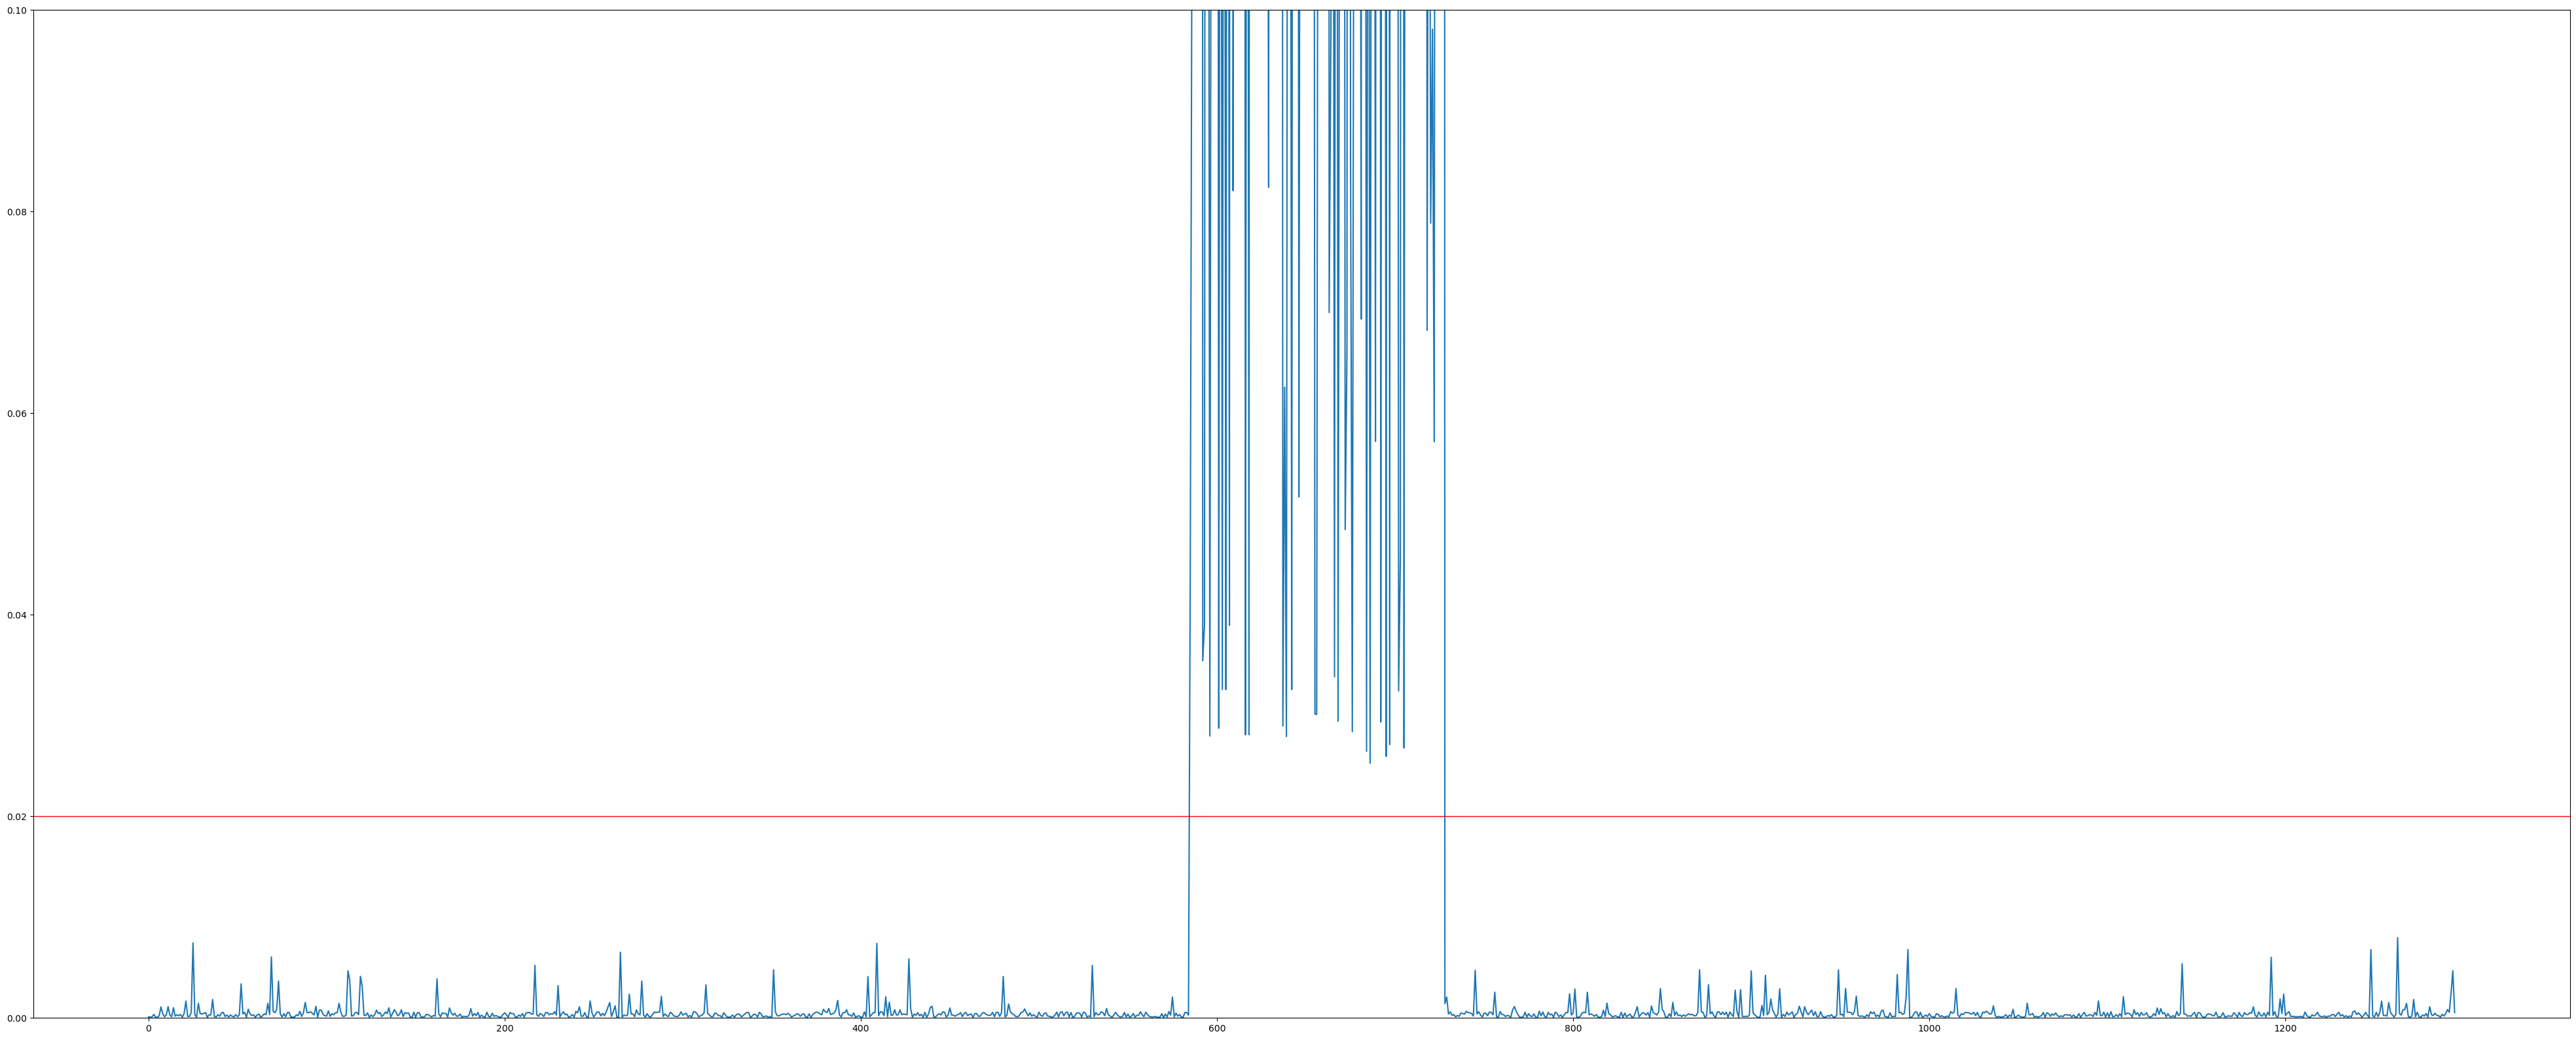

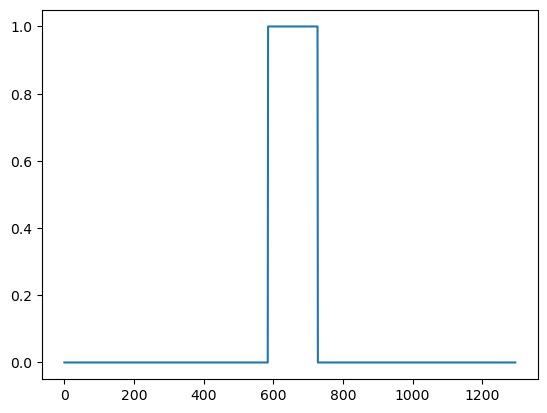

(1107, 7)
1


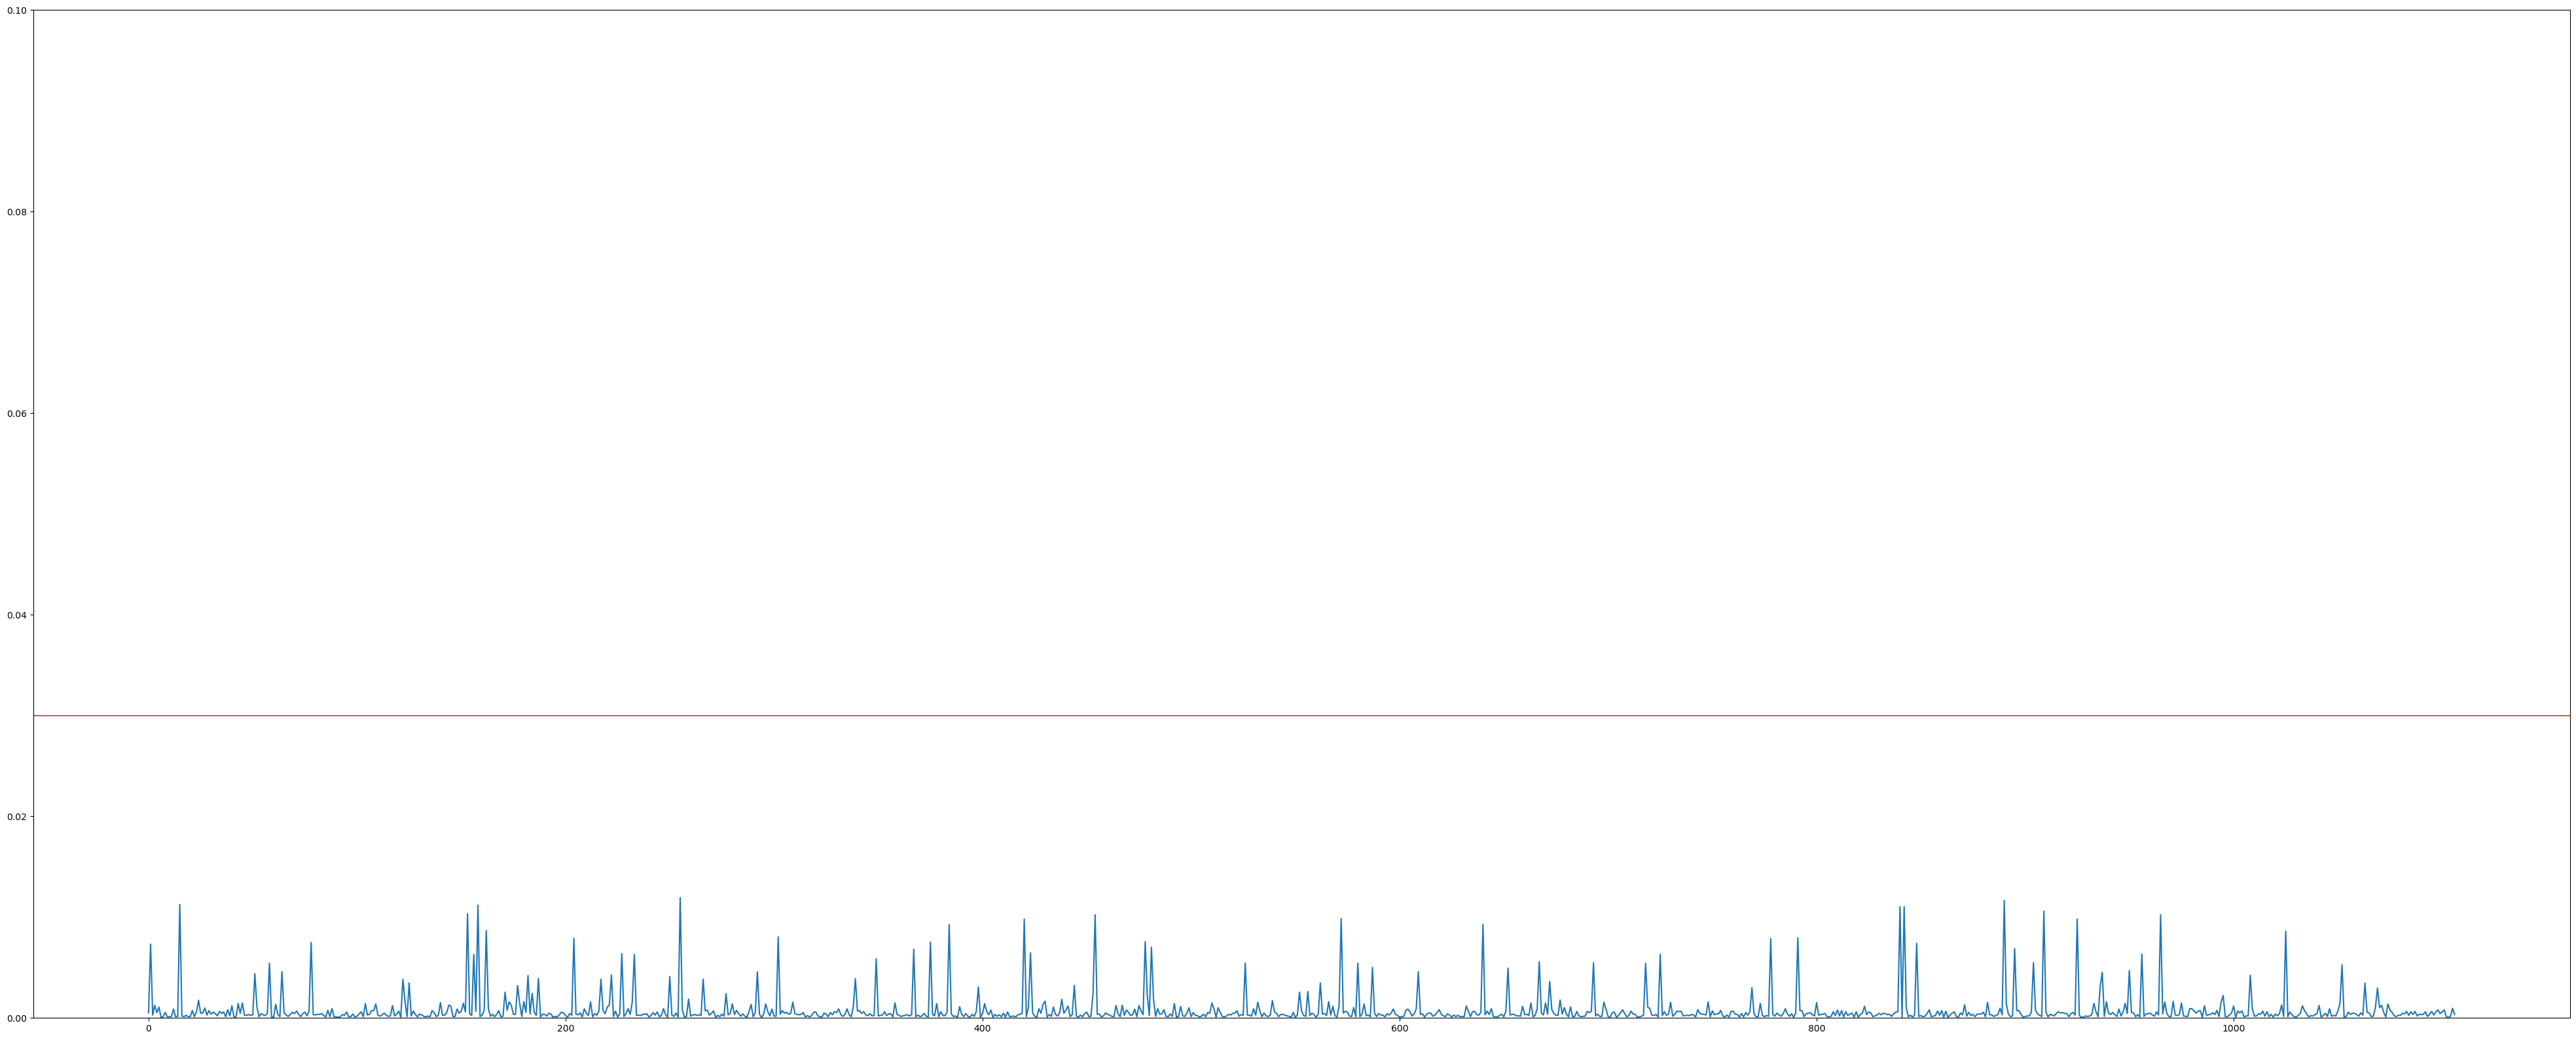

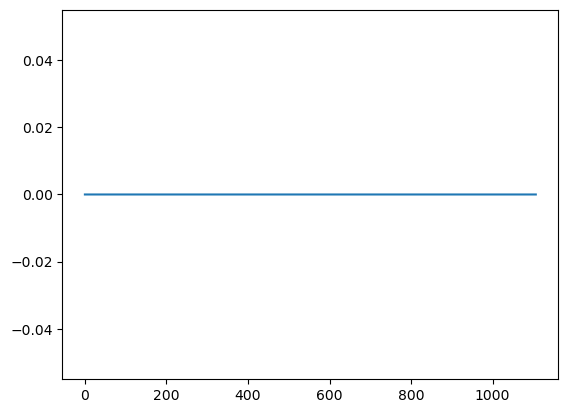

(1098, 7)
2


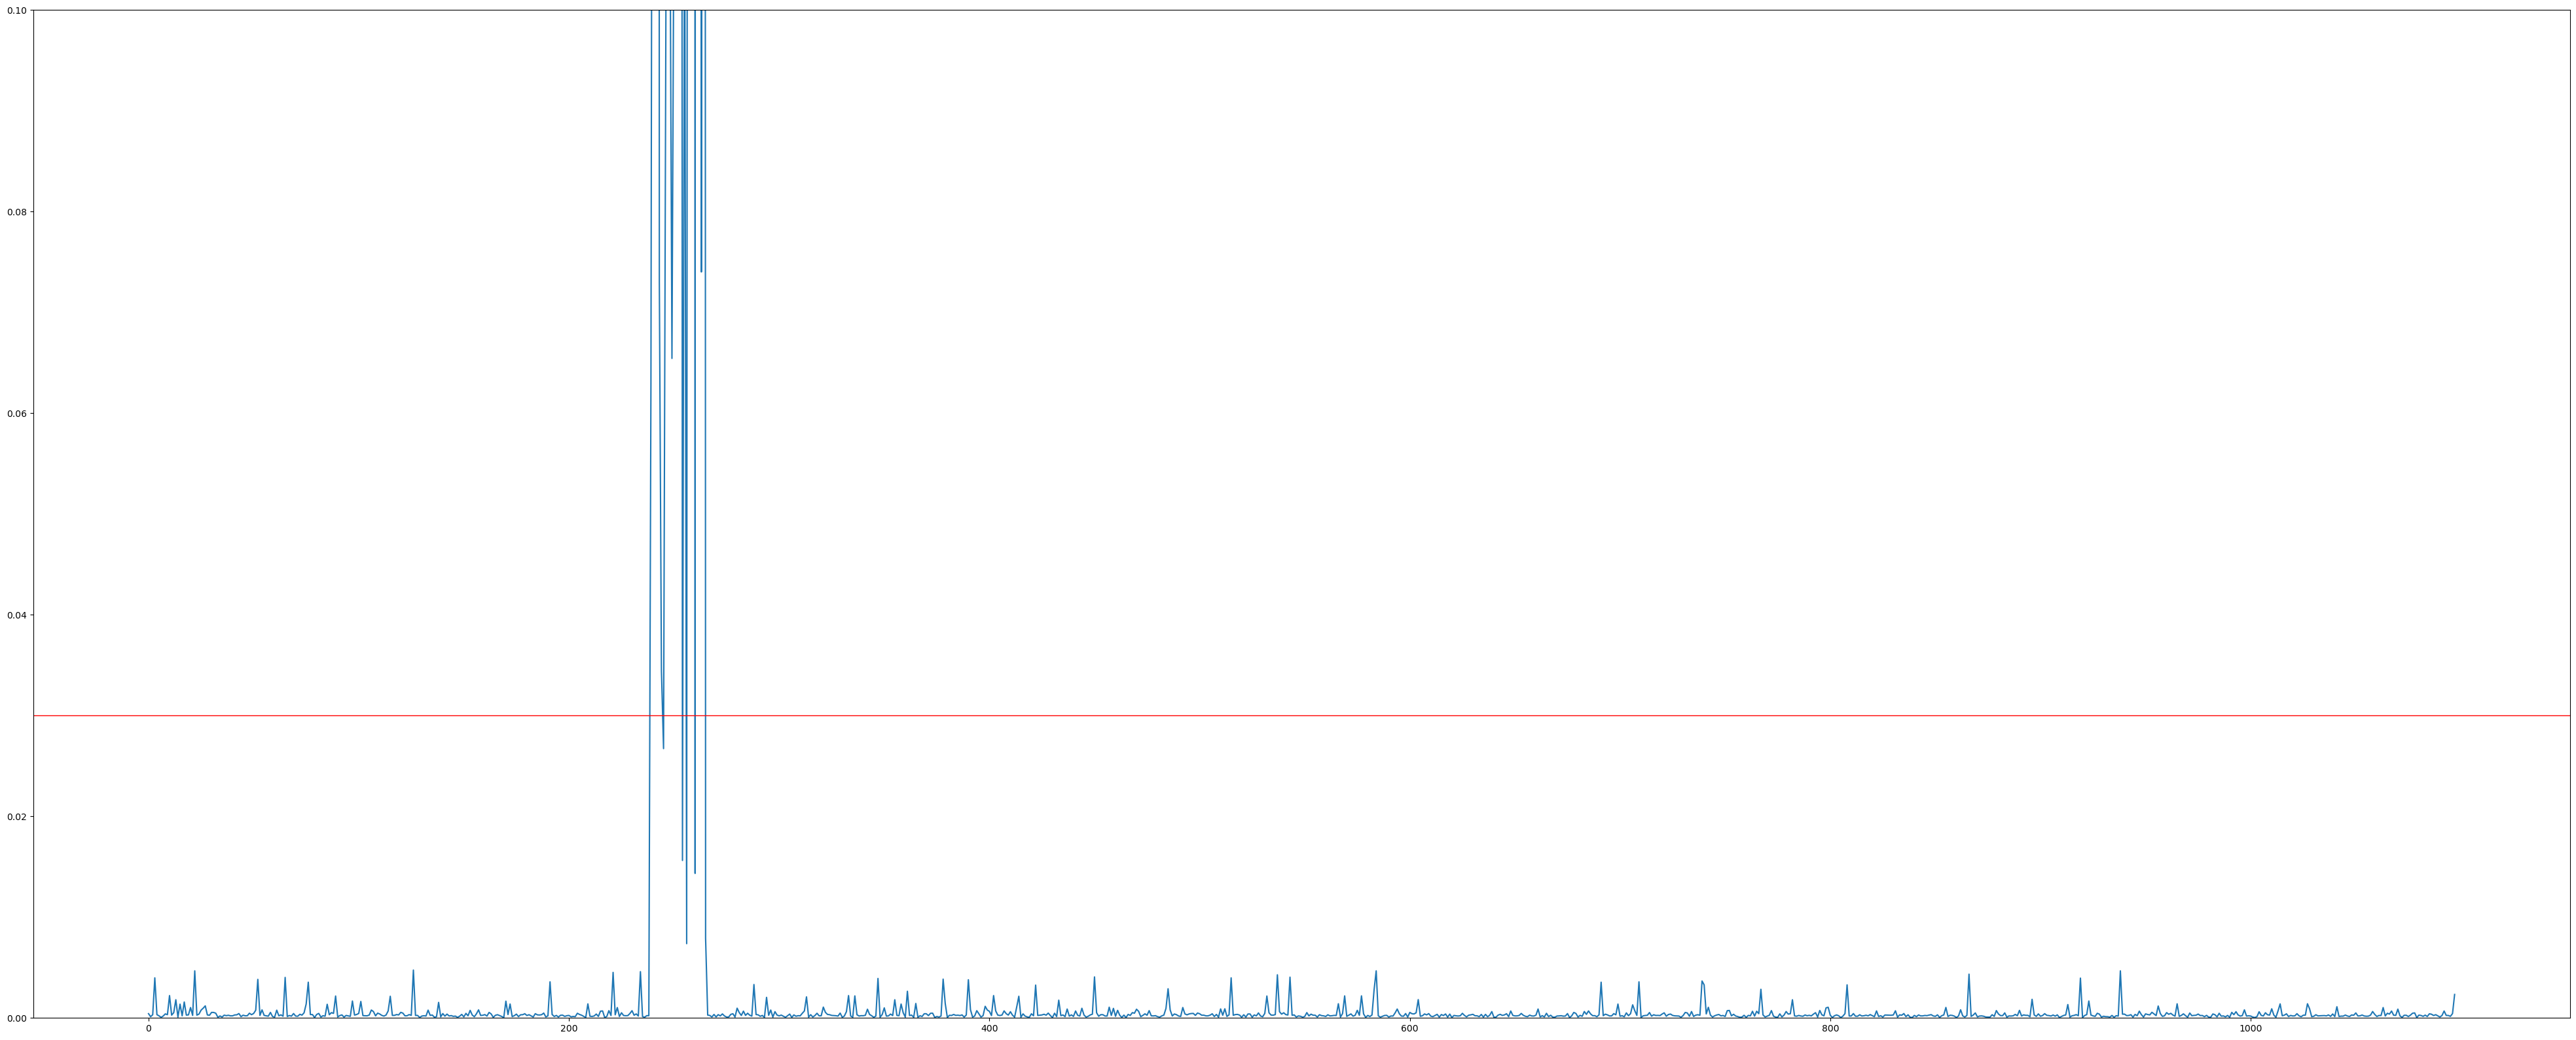

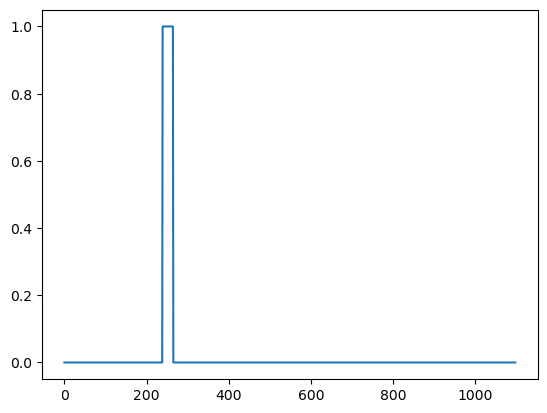

(918, 7)
3


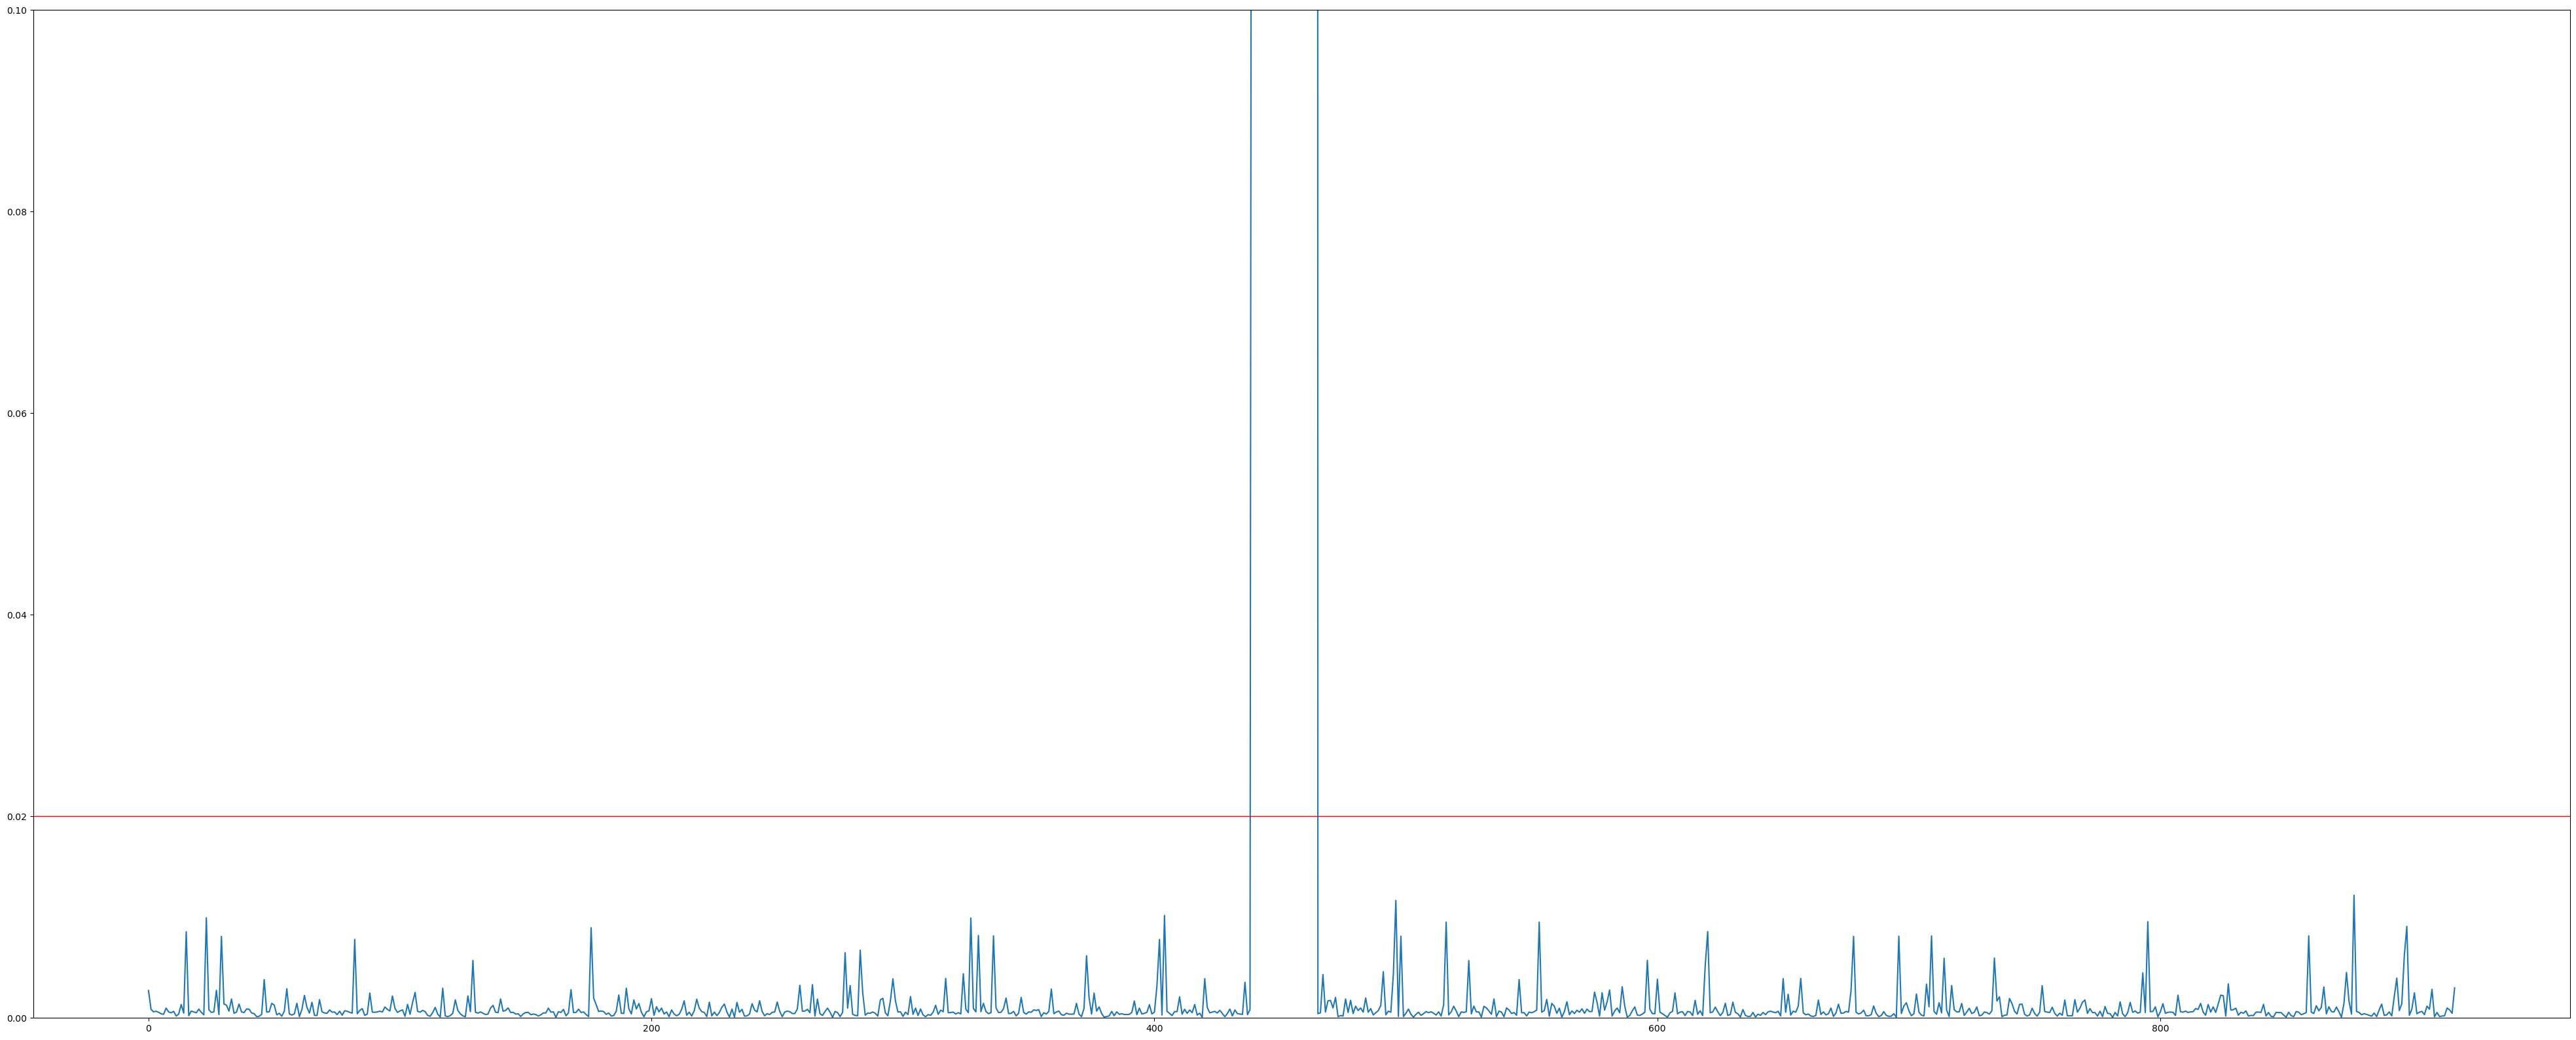

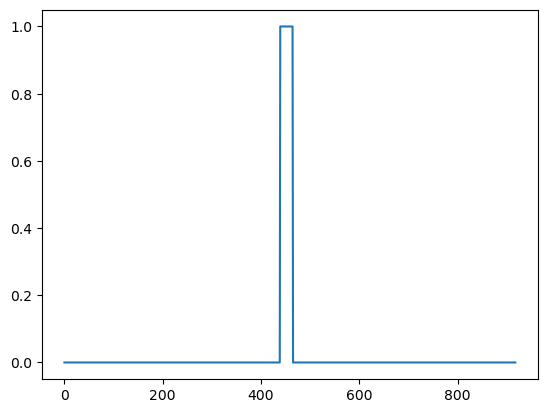

(918, 7)
4


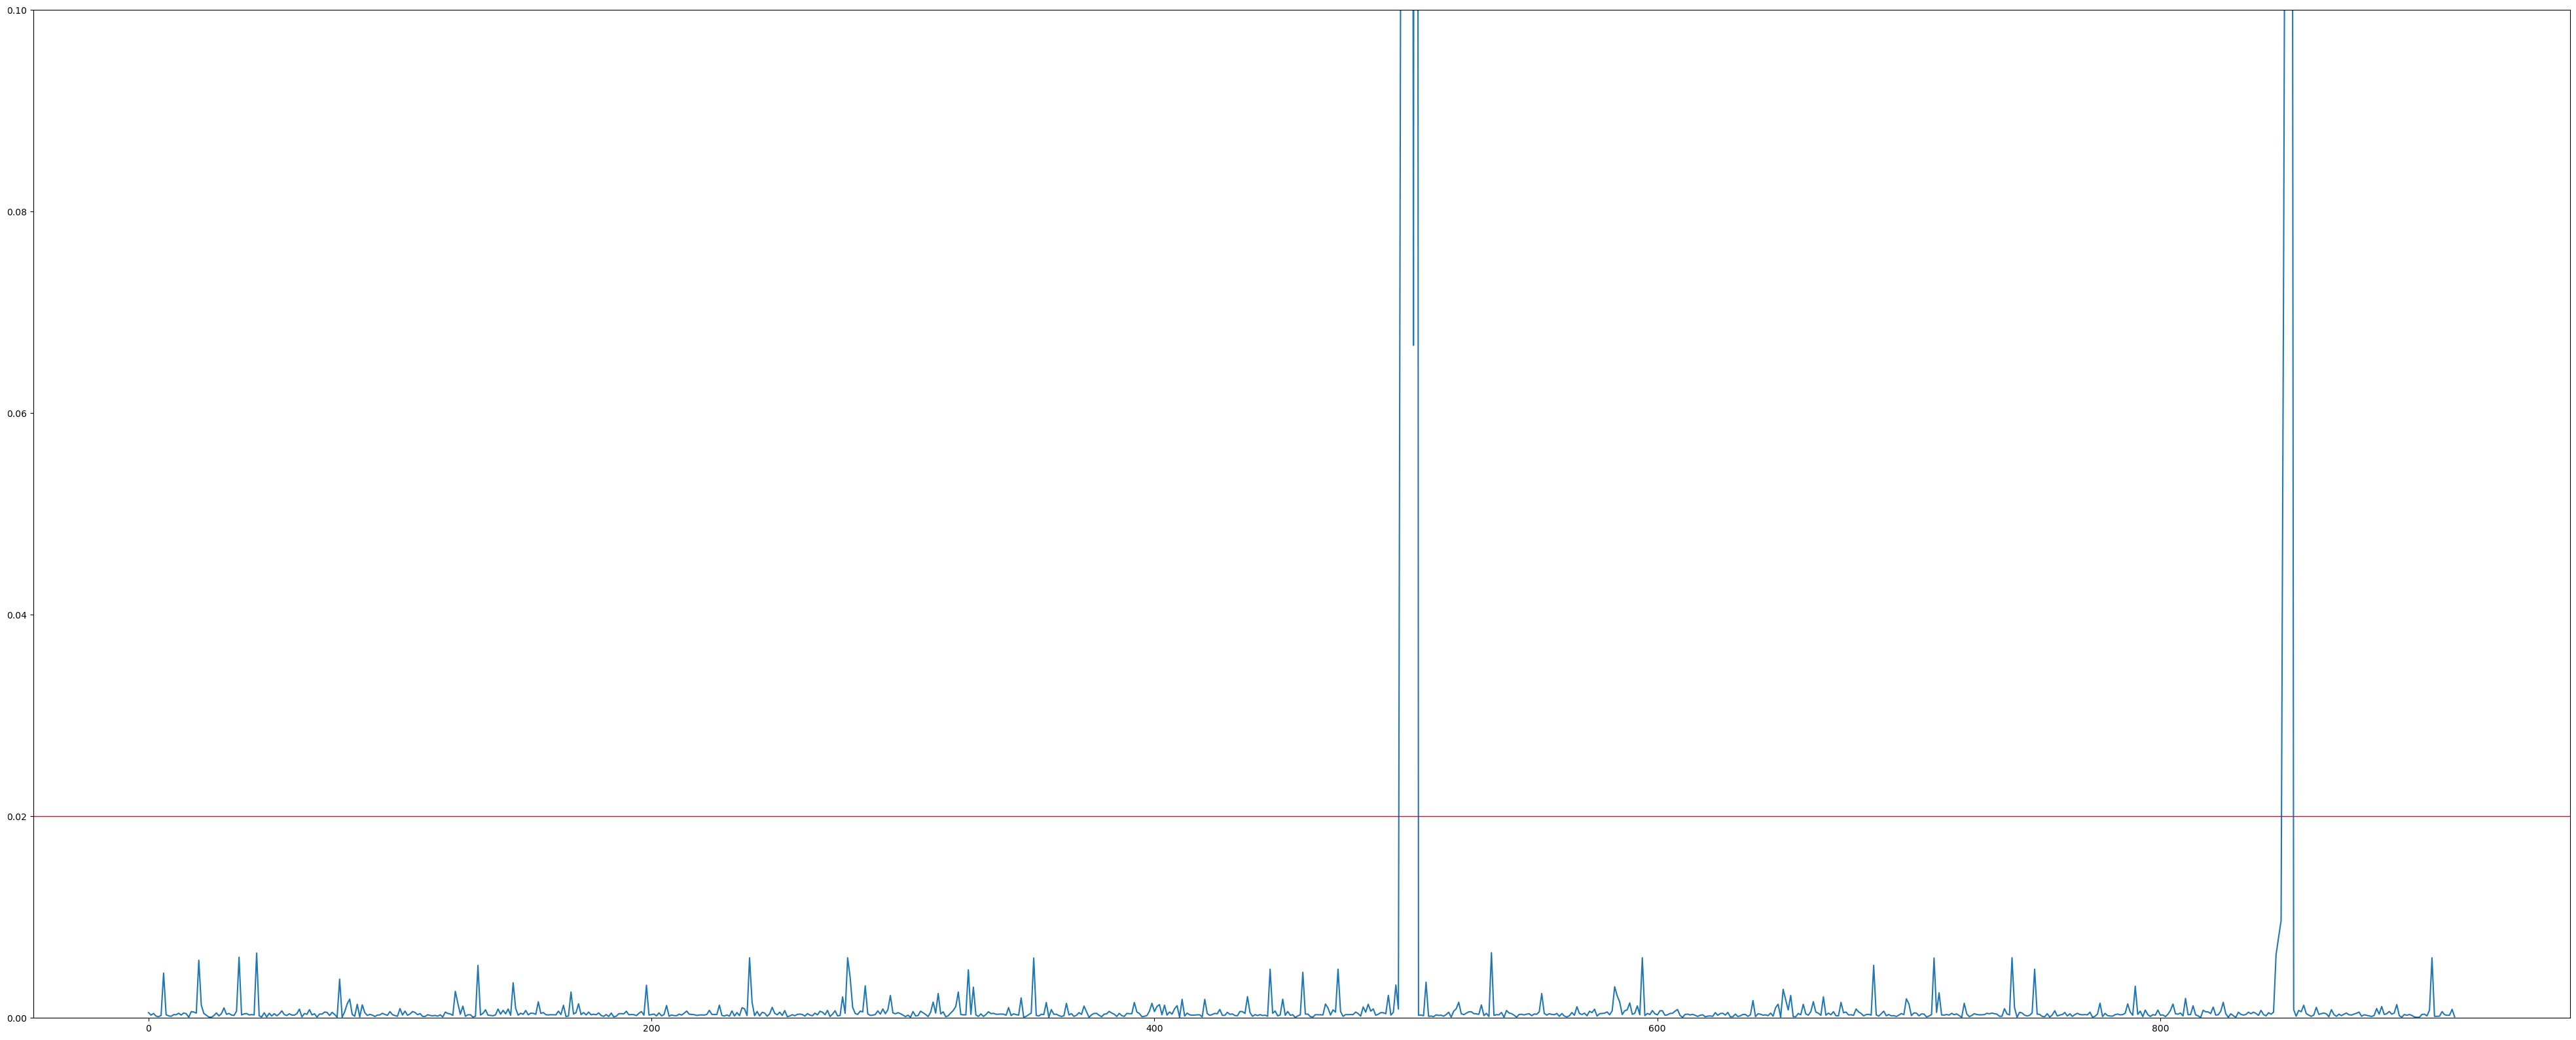

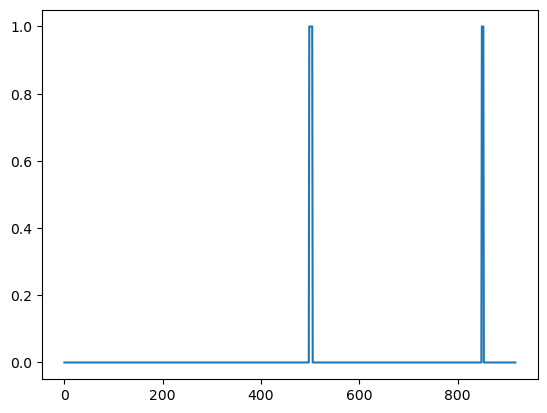

(747, 7)
5


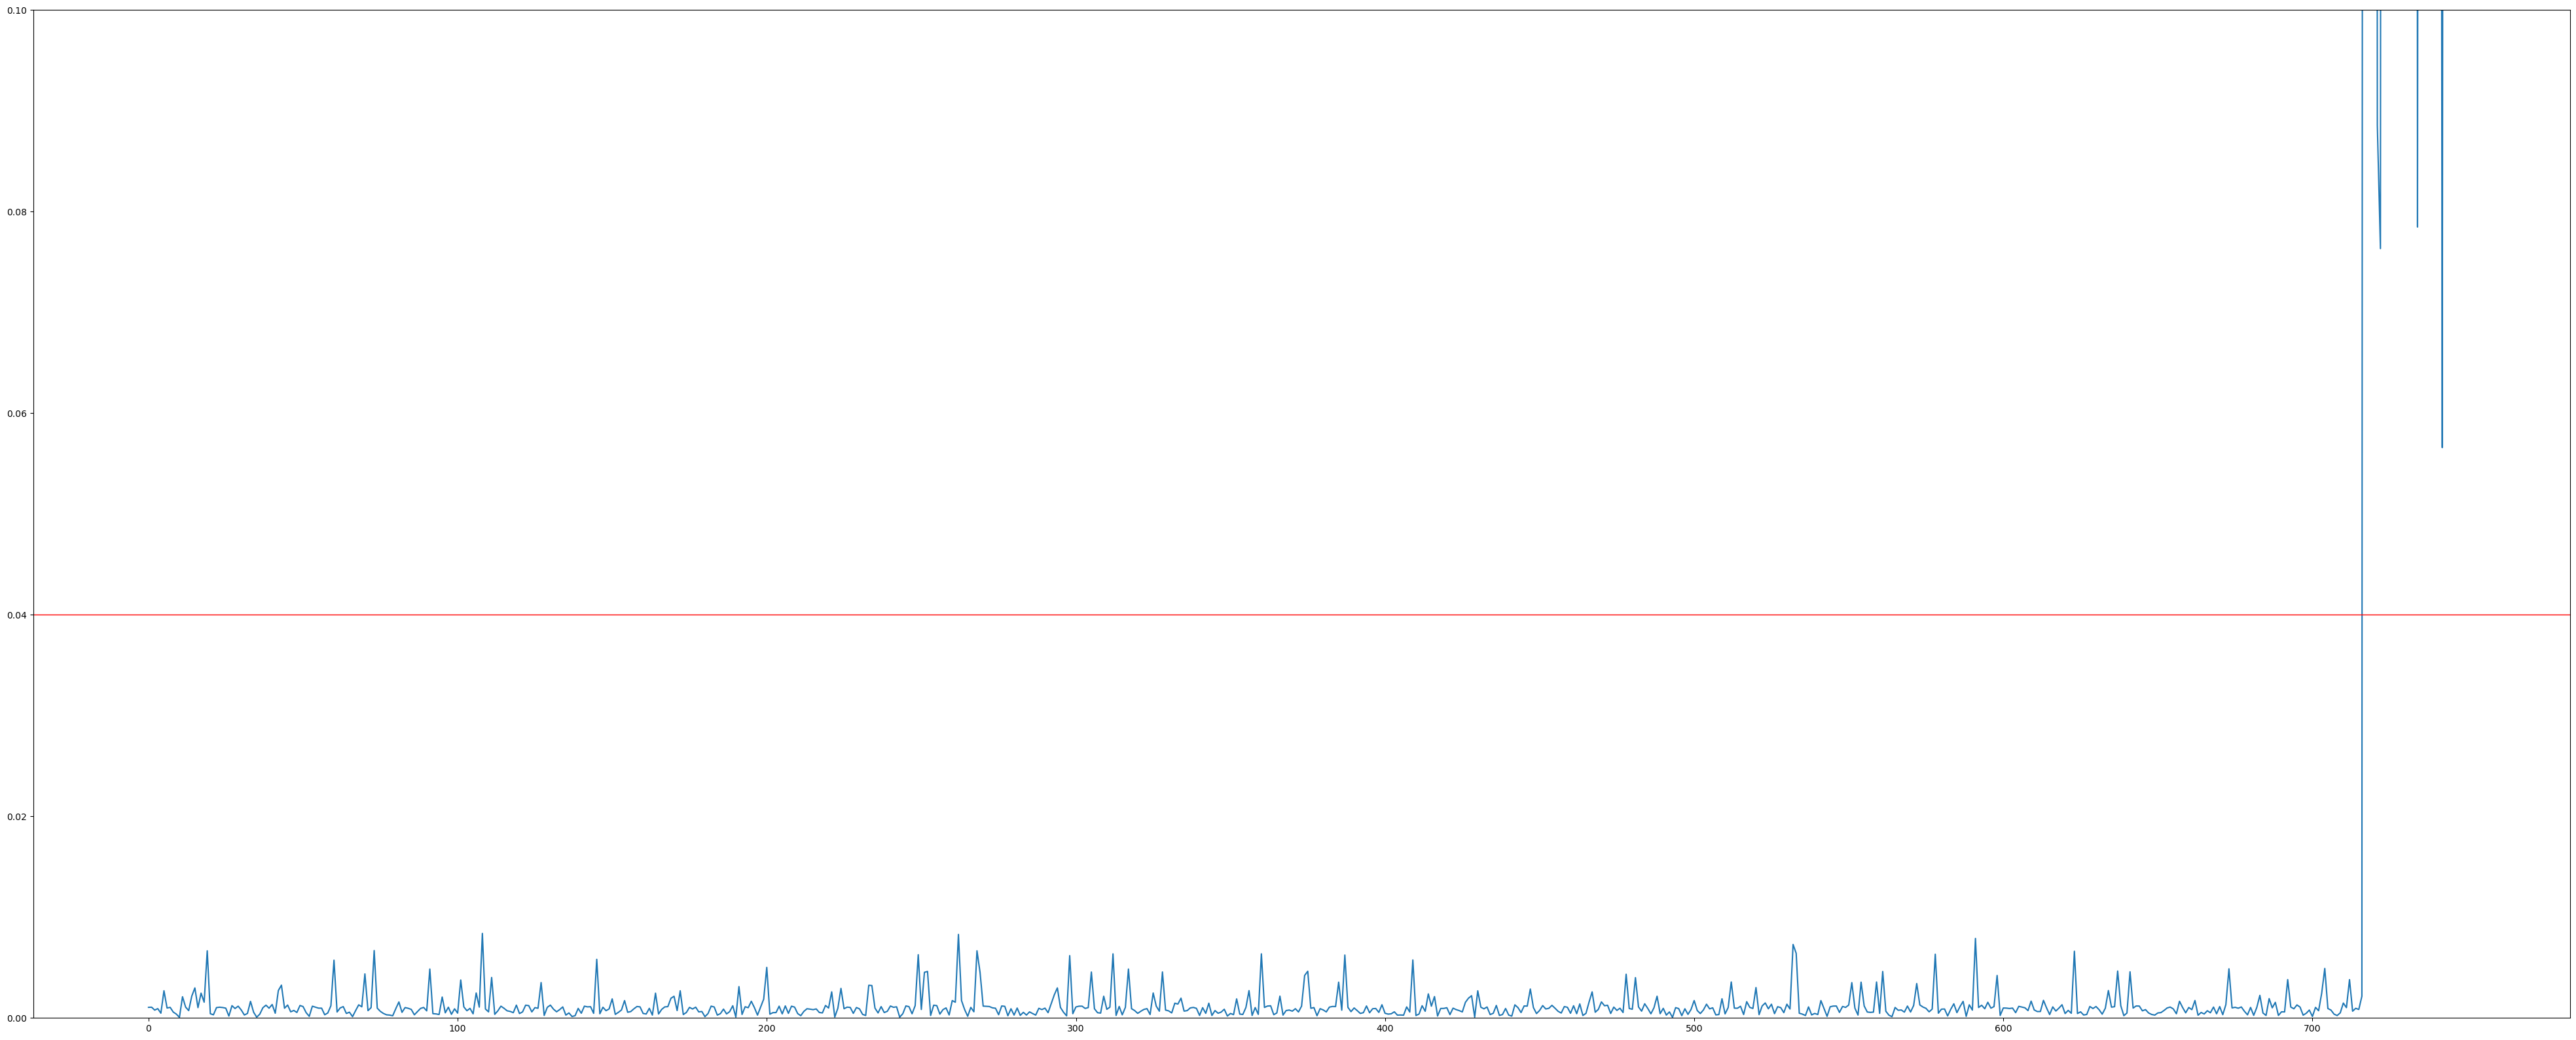

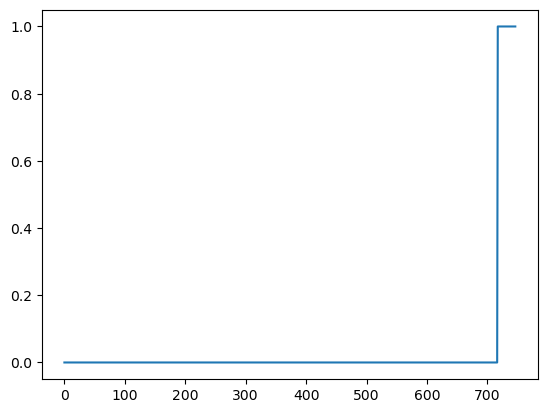

(747, 7)
6


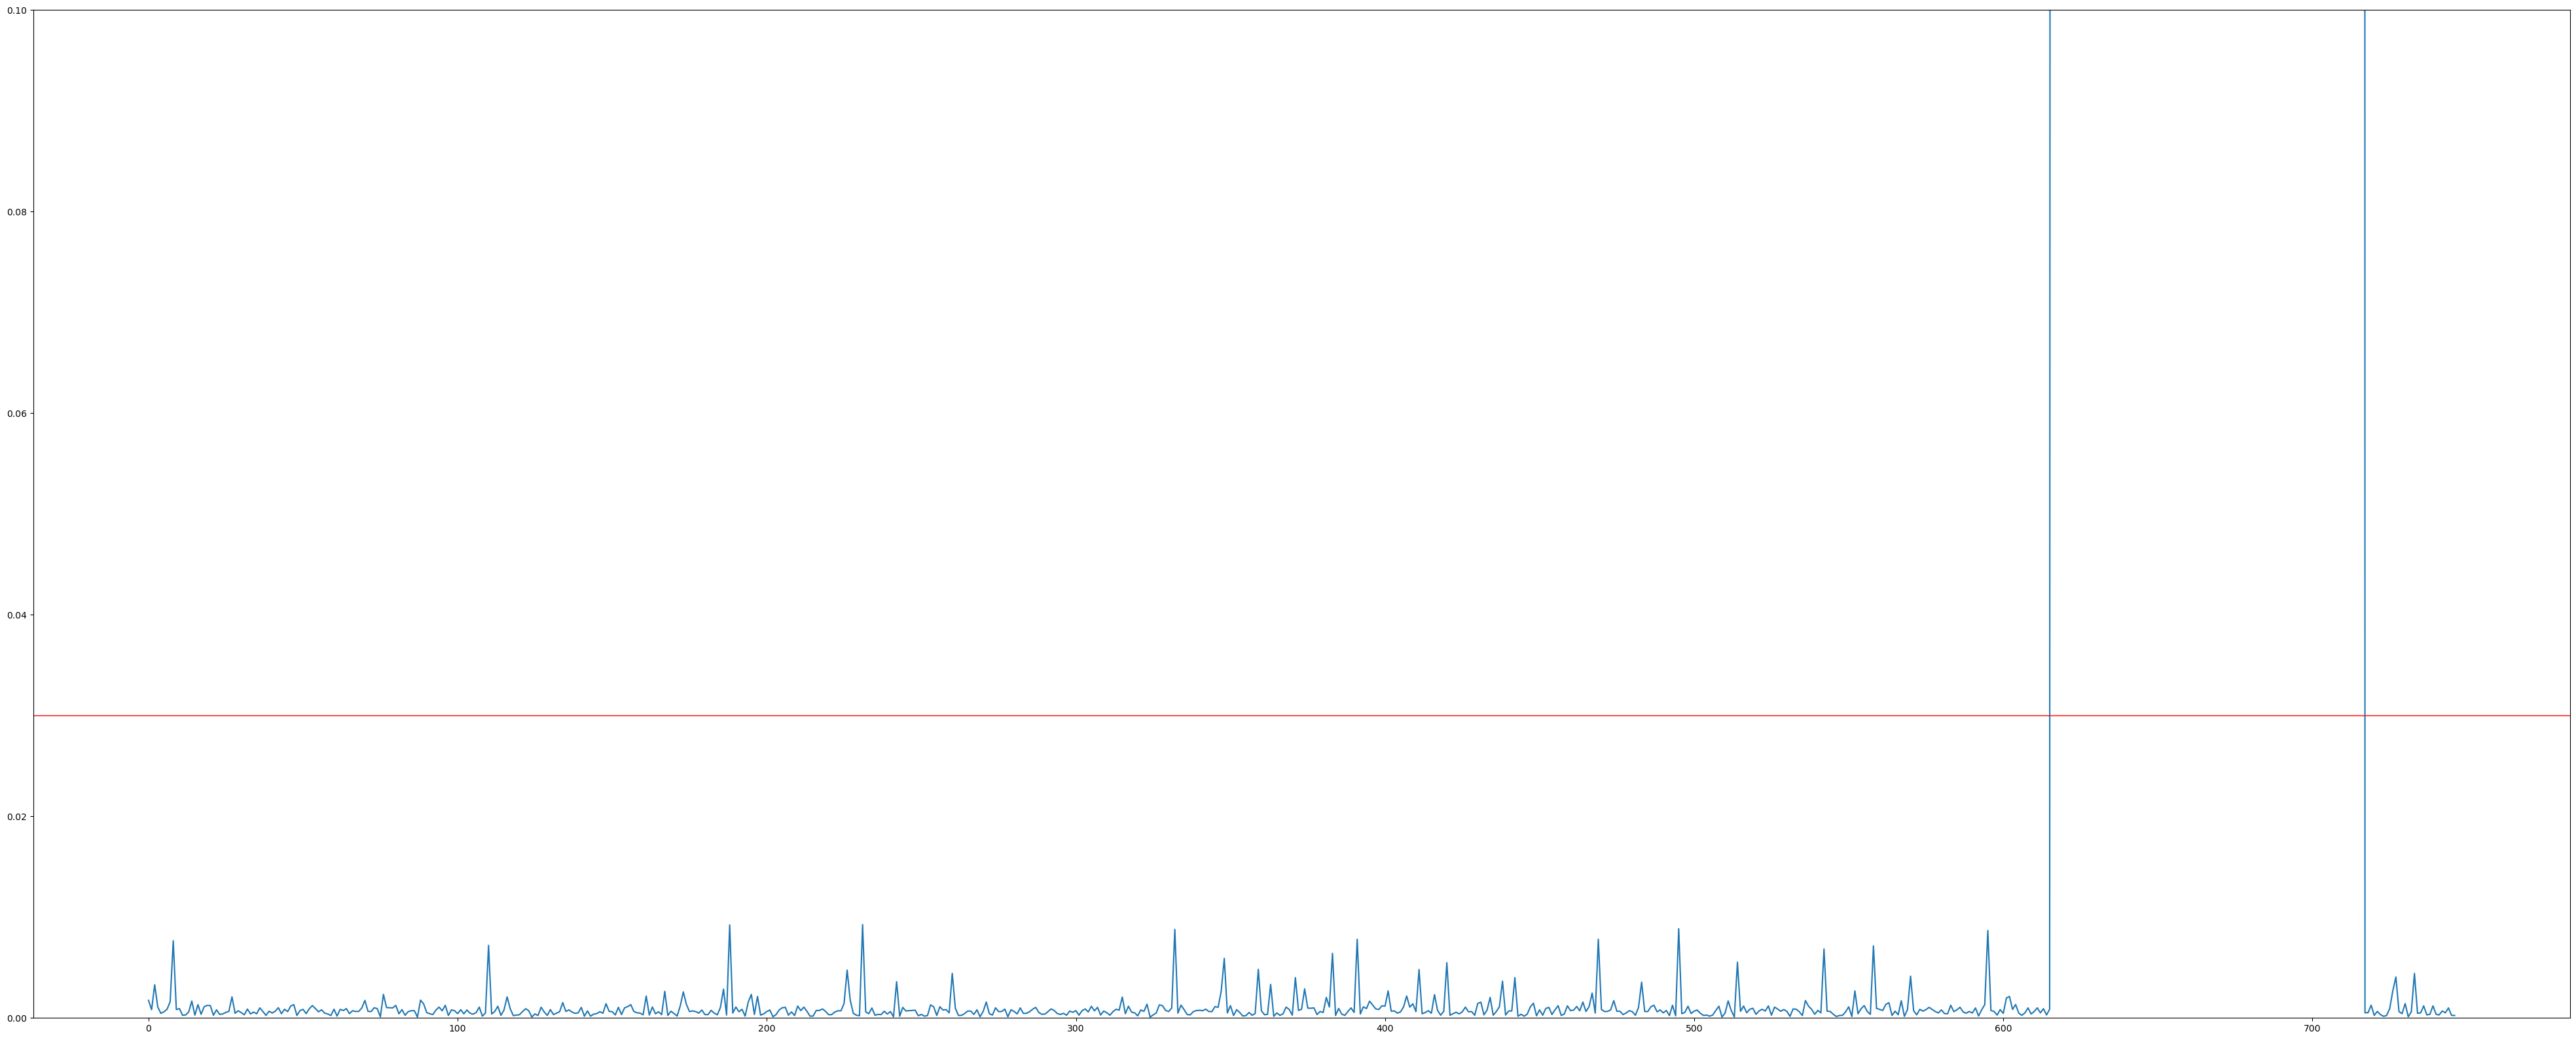

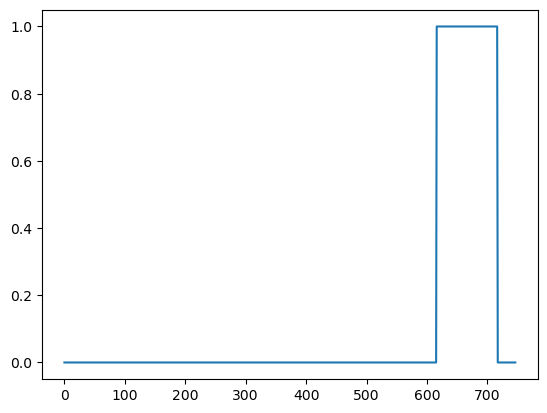

(558, 7)
7


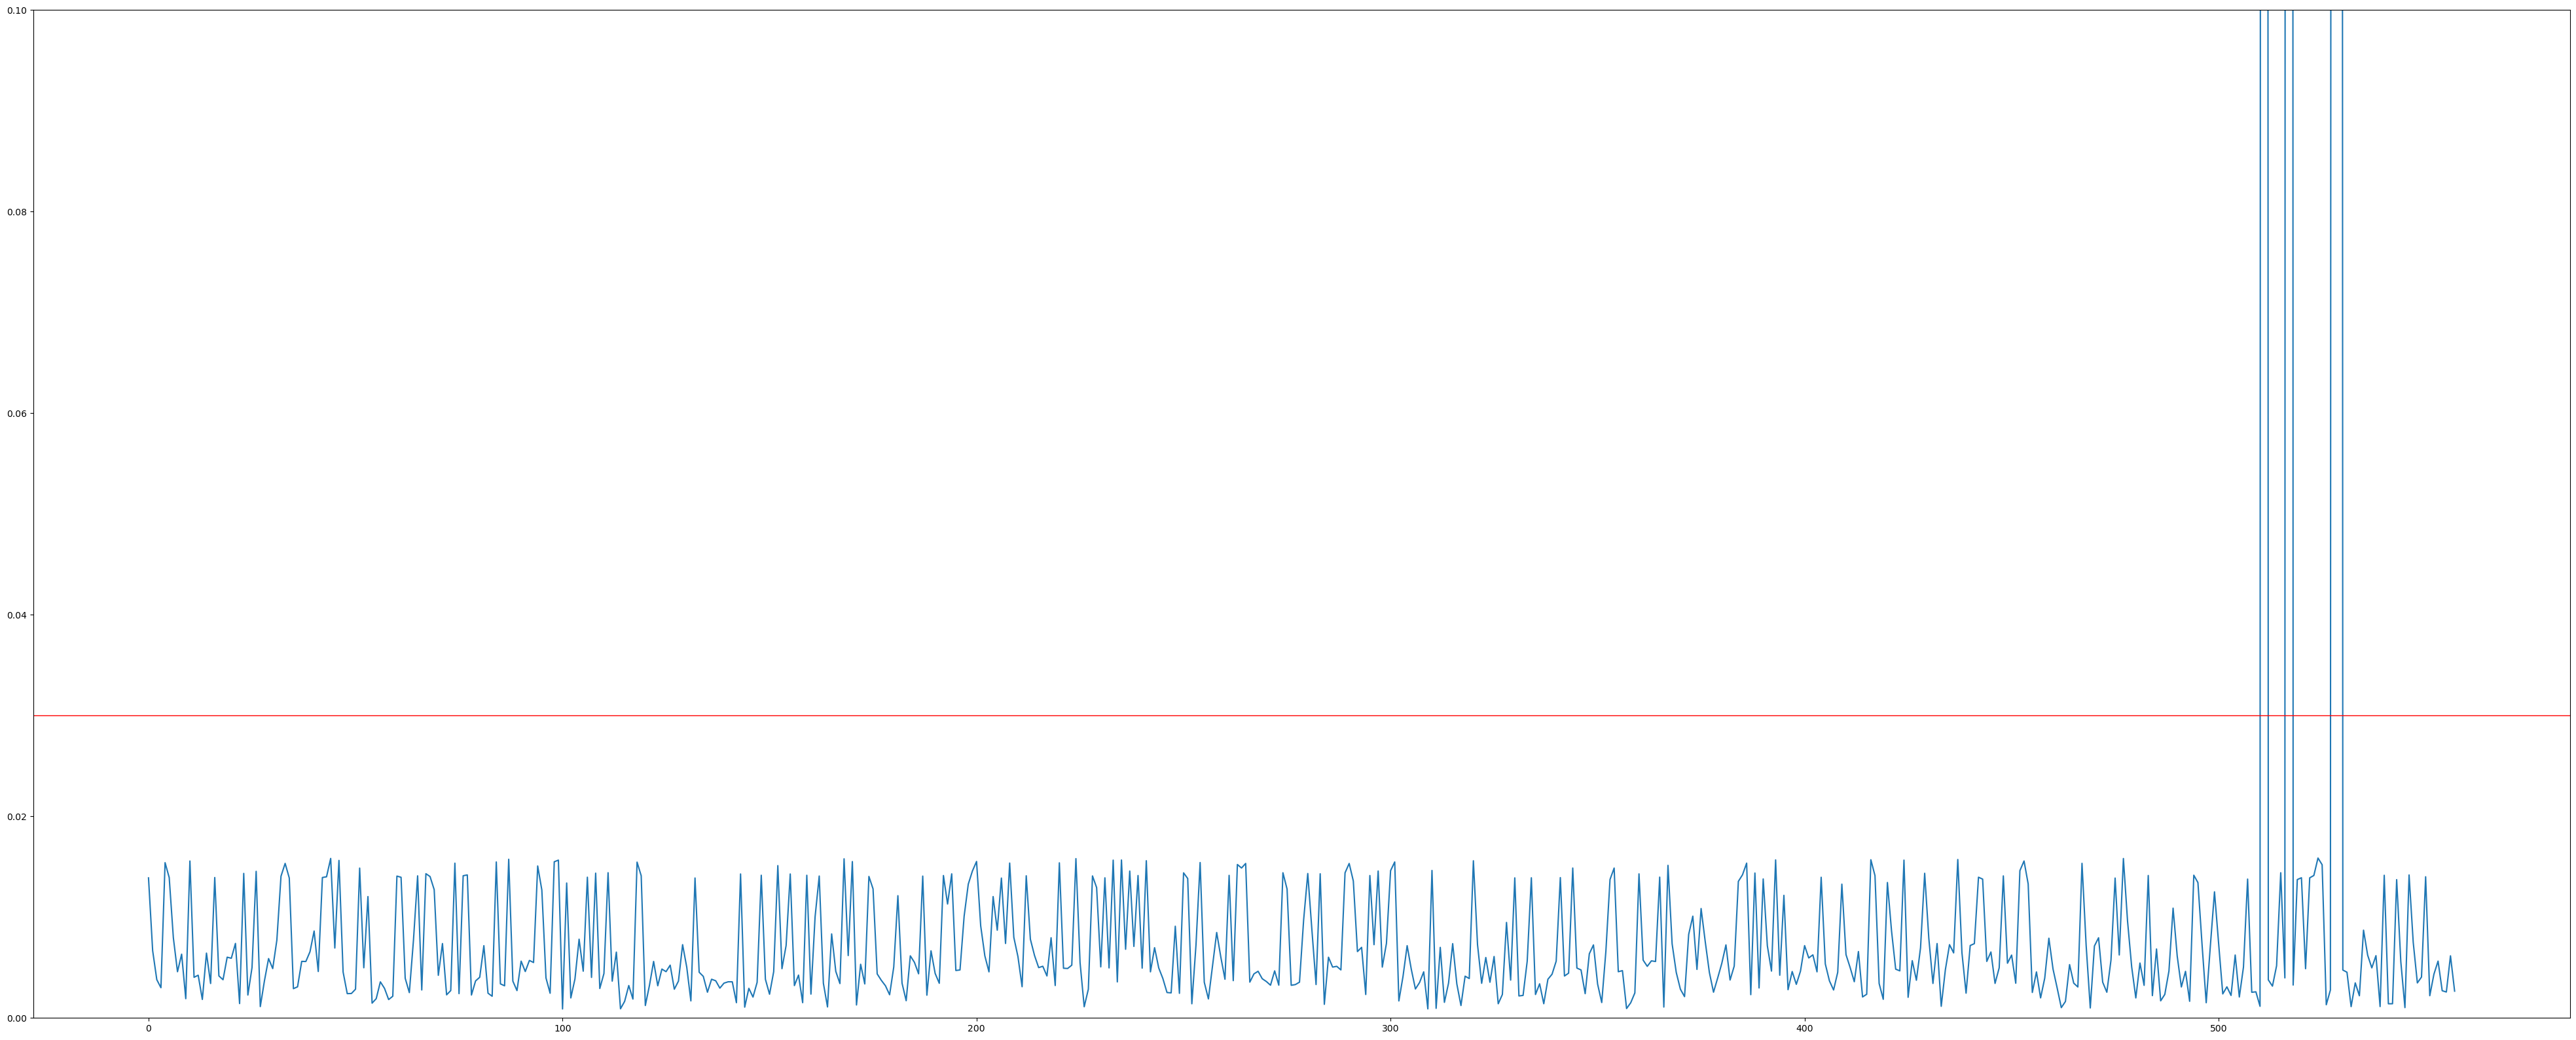

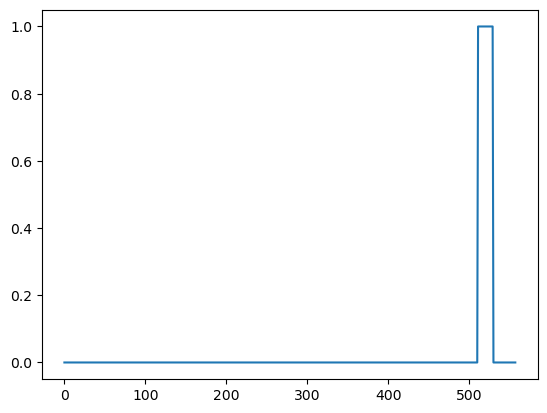

In [45]:
pred = []
threshold = [0.02, 0.03, 0.03, 0.02, 0.02, 0.04, 0.03, 0.03]
for i in range(8):
    pretrained_model = torch.load('./' + MODEL_NAME+str(i)+'.pth')
    pretrained_model = pretrained_model.to(device)
    pretrained_model.eval()
    summary(pretrained_model)

    test_type = test_df.loc[test_df['type']==i]
    test_data_drop = test_type.drop('type', axis=1)
    test_x = scaler_list[i].transform(test_data_drop)
    print(test_x.shape)
    
    test_dataset = MyDataset(test_x)
    test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=False)
    print(i)
    test_loss = []
    mse_list = []
    with torch.no_grad():
        for x in iter(test_loader):
            x = x.float().to(device)
            _x,_ = pretrained_model(x)
            error = x-_x
            mse = np.mean(np.power(error.numpy(),2),axis=1)
            mse_list.extend(mse)
    
    plt.figure(figsize=(50,20))
    plt.plot(mse_list)
    plt.ylim([0,0.1])
    plt.axhline(y=threshold[i], color='r', linewidth=1)
    plt.show()
    
    mse_arr = torch.tensor(mse_list)
    tmp = torch.where(mse_arr > threshold[i], 1, 0).detach().tolist()
    flag = 0
    for idx in range(len(tmp)-20):
        for k in range(2,20):
            if tmp[idx]==1 and tmp[idx+k]==1:
                for j in range(1,k):
                    tmp[idx+j] =1
                    
    #for idx in range(len(tmp)):
    #    if tmp[idx] == 1 and idx > 1 and idx < len(tmp)-2:
    #        tmp[idx-2] = 1
    #        tmp[idx-1] = 1
    
    plt.plot(tmp)
    plt.show()
    
            
    pred += tmp


#train start

In [47]:
zero = 0
one = 0
for i in range(len(pred)):
    if pred[i] == 0:
        zero = zero+1
    else:
        one = one+1    
print(f'{zero}, {one}')

7033, 356


In [25]:
submit = pd.read_csv('./dataset/answer_sample.csv')
submit['label'] = pred
submit.to_csv(f'./AE_6.csv')